# 1. Install and Import Dependencies

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
!pip install stable-baselines3[extra] protobuf==3.20.*

In [8]:
!pip install mss pyautogui pytesseract

In [5]:
!pip install gymnasium

In [12]:
!pip install gym

In [6]:
!pip install pillow

In [1]:
# MSS for screen capture
from mss import mss
# Sending commands
import pyautogui
# Opencv for frame processing
import cv2
# Transformational framework
import numpy as np
# OCR for text extraction
import pytesseract
from PIL import Image
# Visualize captured frames
from matplotlib import pyplot as plt
#Bring in time for pauses
import time
# Environment components
from gymnasium import Env
from gymnasium.spaces import Box, Discrete


# 2. Build the Environment

## 2.1 Create Environment

In [27]:
class CookieRun(Env):
  #Setup the environment action and observation shapes
  def __init__(self, monitor_num = 2):
    super().__init__()
    self.observation_space = Box(low=0, high=255, shape=(1,90,120), dtype=np.uint8)
    self.action_space = Discrete(3)

    self.cap = mss()
    mon = self.cap.monitors[monitor_num]
    # game window
    self.game_location = {"top": mon["top"] + 400, "left": mon["left"] + 500, 'width':1500, 'height':800, "mon": monitor_num} # (2560, 1600)
    # gameover window
    self.done_location = {'top':260, 'left':780, 'width':337, 'height':344, "mon": monitor_num}
    file = cv2.imread('./done.png')
    self.img = cv2.cvtColor(file, cv2.COLOR_BGR2HSV)
    self.img_hist = cv2.calcHist([self.img], [0,1], None, [180,256], [0,180,0, 256])
    cv2.normalize(self.img_hist, self.img_hist, 0, 1, cv2.NORM_MINMAX)
    # reset x window
    self.x_location = {'top':192, 'left':1393, 'width':84, 'height':88, "mon": monitor_num}
    file = cv2.imread('./close.png')
    self.x_img = cv2.cvtColor(file, cv2.COLOR_BGR2HSV)
    self.x_img_hist = cv2.calcHist([self.x_img], [0,1], None, [180,256], [0,180,0, 256])
    cv2.normalize(self.x_img_hist, self.x_img_hist, 0, 1, cv2.NORM_MINMAX)
    # score window
    self.score_location = {'top':160, 'left':760, 'width':350, 'height':64}
    # health window
    self.health_location = {'top' : 88, 'left':509, 'width':1188, 'height':10}
    #Sliding parameter
    self.sliding = False
    #Reward parameter
    self.pre_reward = 1187
    self.invincible_time = 0
    #Color palette
    self.colorPaletteArray = [[219, 147, 75], [65,30,23], [254, 225, 76], [61, 194, 237], [204, 204, 204], [254, 146, 173], [243, 138, 73], [255, 4, 1], [171, 140, 84], [191, 203, 47]]


  # What is called to do, something in the game
  def step(self, action):
    #Action key - 0 : Idle / 1 : jump / 2 : slide
    action_map = {
        0:'idle',
        1:'jump',
        2:'slide'
    }
    if action == 1:
        if not(self.sliding):
            pyautogui.click(x=206, y=869)
    if action == 2:
        if self.sliding:
            pyautogui.mouseDown(x=1625, y=889)
        else:
            pyautogui.mouseUp(x=1625, y=889)
        self.sliding = not(self.sliding)

    #Checking whether game is done
    done, done_cap = self.get_done()
    #Get the next observation
    new_observation = self.get_observation()
    
    #set reward
    #current_score = np.array(self.cap.grab(self.score_location))
    #plt.imshow(current_score)
    #str = pytesseract.image_to_string(current_score,config='digits -c tessedit_char_whitelist=0123456789 -c tessedit_char_blacklist=\abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,.\n')
    #str = str[2:]
    #if str:
    #    try:
    #        score = int(str)
    #        reward = (score - self.pre_reward)/1000
    #        self.pre_reward = score 
    #    except:
    #        reward = self.pre_reward/1000
    #else:
    #    reward = self.pre_reward/1000
    current_health = np.array(env.cap.grab(env.health_location))
    c = np.arange(0,1187,1)
    cnt = 0
    for a in c:
        if current_health[5][a][2] > 200:
            cnt += 1
    reward = 0
    if cnt - self.pre_reward <= -30:
        reward = -30
        self.invincible_time = 5
    elif self.invincible_time >0:
        reward = 0
        self.invincible_time = self.invincible_time - 1
    else:
        reward = 10
    if cnt != 0:
        self.pre_reward = cnt
        
    info = {'arg1':1}

    return new_observation, reward, done, False, info

  # Restart the game
  def reset(self, seed=None):
    time.sleep(15)
    pyautogui.click(x=908, y=936)
    time.sleep(1)
    pyautogui.click(x=908, y=936)
    time.sleep(6)
    pyautogui.click(x=1044, y=866)
    time.sleep(3)
    pyautogui.click(x=1044, y=866)
    time.sleep(1)
    x_cap = np.array(self.cap.grab(self.x_location))
    x_cap = cv2.cvtColor(x_cap, cv2.COLOR_BGR2HSV)
    x_hist = cv2.calcHist([x_cap], [0,1], None, [180,256], [0,180,0, 256])
    cv2.normalize(x_hist, x_hist, 0, 1, cv2.NORM_MINMAX)
    ret = cv2.compareHist(self.x_img_hist, x_hist, cv2.HISTCMP_CORREL)
    if ret > 0.9:
        pyautogui.click(x=1393, y=192)
        time.sleep(6)
    pyautogui.click(x=1534, y=900)
    time.sleep(1)
    pyautogui.click(x=1170, y=693)
    time.sleep(3.5)
    info = {'arg1':0}
    return self.get_observation(), info

  
    
  def preprocess_kcolor(self, rgb):
    '''
    ## Color palette

    # 캐릭터
    219, 147, 75
    # 배경
    65, 30, 23    
    # 노란코인
    254, 225, 76
    # 블루빈
    61, 194, 237
    # 은색
    204, 204, 204
    # 분홍색
    254, 146, 173
    # 소시지
    243, 138, 73
    # 빨간색
    255, 4, 1
    # 황동색
    171, 140, 84
    # 연두색
    191, 203, 47
    '''
    print(rgb[0][0])
    
    for row in range(0, rgb.shape[0]):
      for col in range(0, rgb.shape[1]):
          shortestIdx = 0
          shortestDist = 200000.0
          for idx, value in enumerate(self.colorPaletteArray):
            currentDist = self.get_distance(rgb[row][col], value)
            if currentDist < shortestDist:
              shortestDist = currentDist
              shortestIdx = idx
          rgb[row][col] = self.colorPaletteArray[shortestIdx]
    
    return rgb
    
    
  def get_distance(self, rgb, palette):
    return (rgb[0] - palette[0])**2 + (rgb[1] - palette[1])**2 + (rgb[2] - palette[2])**2
  
  # Get the part of the obeservation of the game that we want
  def get_observation(self):
    # Get screen capture of game
    raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
    # RGBscale
    rgb = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)
    
    # resize
    resize = cv2.resize(rgb, (120,90))
    resize_return = resize.copy()
    # Add channels first
    channel = np.reshape(resize, (3,90,120))
    
    preprocessed = self.preprocess_kcolor(resize)
    
    return rgb, resize_return, preprocessed

  # Get the gameover state - Use opencv2 to compare image
  def get_done(self):
    done_cap = np.array(self.cap.grab(self.done_location))
    done_cap = cv2.cvtColor(done_cap, cv2.COLOR_BGR2HSV)
    done_hist = cv2.calcHist([done_cap], [0,1], None, [180,256], [0,180,0, 256])
    cv2.normalize(done_hist, done_hist, 0, 1, cv2.NORM_MINMAX)
    done = False
    ret = cv2.compareHist(self.img_hist, done_hist, cv2.HISTCMP_CORREL)
    if ret > 0.9:
        done = True
        self.pre_reward = 1187
    return done, done_cap

In [6]:
x, y = pyautogui.position()
print(x, y)

650 723


## 2.2 Test Environment

[71 57 75]


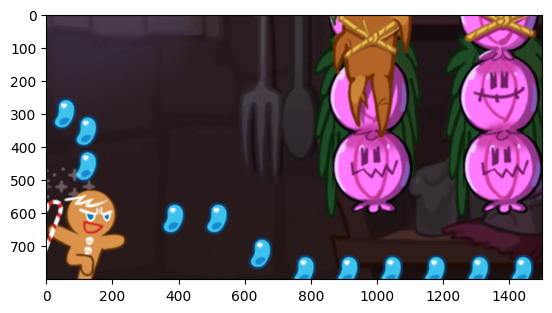

In [31]:
env= CookieRun(2)
auto1, auto2, auto3 = env.get_observation()
plt.imshow(auto1)


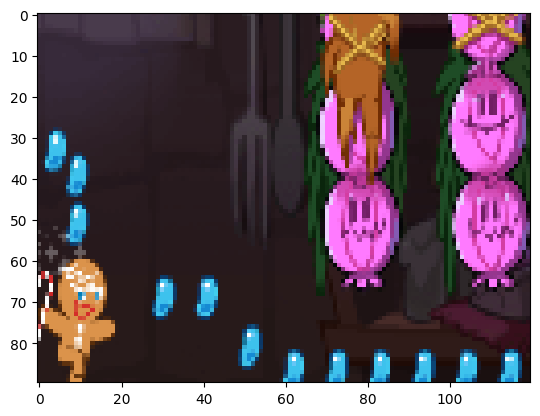

In [32]:
plt.imshow(auto2)

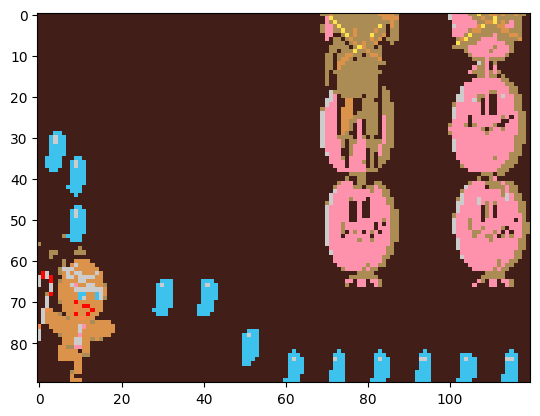

In [33]:
plt.imshow(auto3)

(1600, 2560, 3)
(1600, 2560)
(90, 120)
(1, 90, 120)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
False


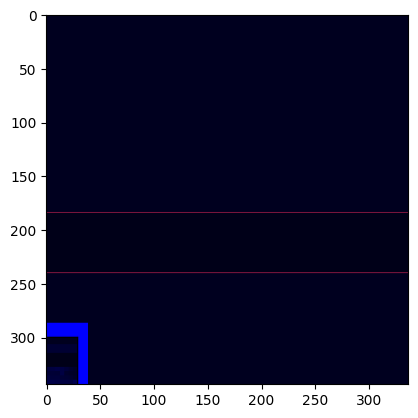

In [122]:
obs = env.get_observation()
done, done_cap = env.get_done()
print(done)
plt.imshow(done_cap)

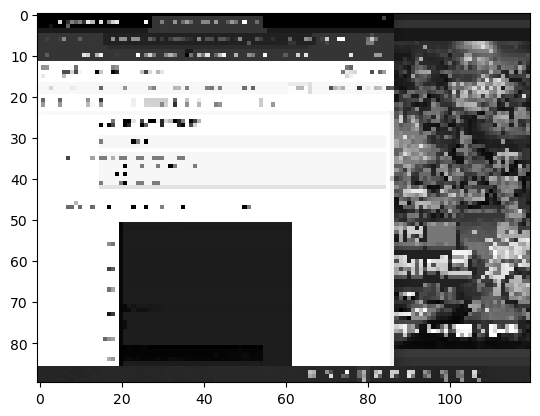

In [14]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.

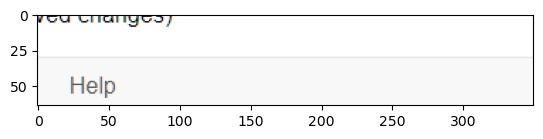

In [69]:
current_score = np.array(env.cap.grab({'top':160, 'left':760, 'width':350, 'height':64}))
plt.imshow(current_score)
str = pytesseract.image_to_string(current_score,config='digits -c tessedit_char_whitelist=0123456789')
str = str[2:]
print("String is " + str)

In [516]:
env.reset()
obs,_,_,_,_ = env.step(1)
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

KeyboardInterrupt: 

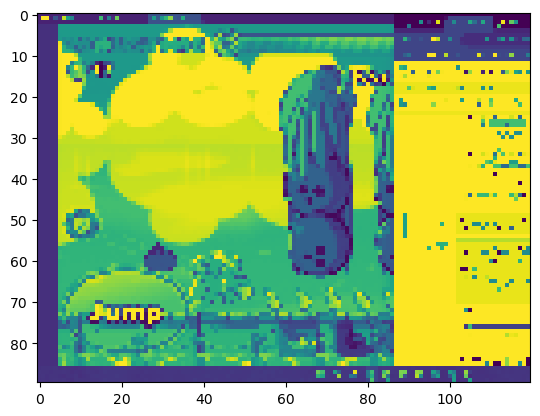

In [544]:
obs,_,_,_,_ = env.step(0)
plt.imshow(obs[0])

1187


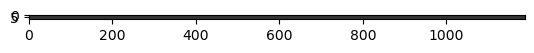

In [395]:
current_health = np.array(env.cap.grab(env.health_location))
plt.imshow(current_health)
c = np.arange(0,1187,1)
cnt = 0
for a in c:
    if current_health[5][a][2] < 200:
        cnt += 1
print(cnt)

# 3. Train the Model

## 3.1 Create Callback

In [26]:
# Import os for file path management
import os
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment
from stable_baselines3.common import env_checker

In [16]:
env_checker.check_env(env)

In [27]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
            
        return True

In [28]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [29]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

## 3.2 Build () and Train

In [30]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [31]:
env = CookieRun()

In [32]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=120000, learning_starts=5, learning_rate = 0.001)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [37]:
model.learn(total_timesteps=1000000, callback=callback)

Logging to ./logs/DQN_16
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 416      |
|    ep_rew_mean      | 3.25e+03 |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5        |
|    time_elapsed     | 313      |
|    total_timesteps  | 1666     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.36     |
|    n_updates        | 37140    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 457      |
|    ep_rew_mean      | 3.59e+03 |
|    exploration_rate | 0.965    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5        |
|    time_elapsed     | 626      |
|    total_timesteps  | 3657     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.08  

FailSafeException: PyAutoGUI fail-safe triggered from mouse moving to a corner of the screen. To disable this fail-safe, set pyautogui.FAILSAFE to False. DISABLING FAIL-SAFE IS NOT RECOMMENDED.

# 4. Test out Model

In [34]:
model.load('train/best_model_130000') 

In [36]:
for episode in range(5): 
    obs = env.reset()[0]
    total_reward = 0
    done = False
    while not done: 
        action, state = model.predict(obs)
        obs, reward, done, _, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))

Total Reward for episode 0 is 5160
Total Reward for episode 1 is 4210
Total Reward for episode 2 is 4520
Total Reward for episode 3 is 4310
Total Reward for episode 4 is 4980
